# An Analysis of EPS Surprise Percent VS Change in Closing Price 

## Introduction

FOMO (Fear of misssing out) is a phenomenon that has causes people to take positions in stocks before a major annoucement either in the stock, sector or the economy. One major annoucement that follows every quarter in the US is the earnings call for respective stocks. During the earnings call, one might be interested to know whether the company beat the analyst estimates for Earnings Per Share (EPS).

Also, the corollary is whether it moves the stock price significantly for that quarter after the announcement.

In this analysis, we are using the percentage change in 3 month closing price for that quarter and plot it wrt to the EPS surprise percent which is the % difference between the estimated EPS and actual EPS for that quarter.

<span style="color:red">Simply put,  *does beating analyst estimates affect stock price positively in the upcoming quarter?* </span>.

We will analyse this using the 30 DOW stocks using Yahoo Finance.

## Install Dependencies

In [127]:
!pip install yahoo-fin tqdm pandas seaborn matplotlib sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 7.7 MB 4.0 MB/s eta 0:00:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=24b840104da57630c3bdc2efb17cff3075a564c9ac03ebd73ee61aeca6fa5317
  Stored in directory: /Users/prakash/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


## Load Dependencies

The module used to scrape data from yahoo finance is yahoo_fin. More details can be found at http://theautomatic.net/yahoo_fin-documentation/

In [140]:
import pandas as pd
from tqdm import tqdm
from yahoo_fin import stock_info as si, options as op, news as ns
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

## Test pulling earning history

We test the API by loading SEA's earning history as a sample and dumping all contents. Pulling out the respective date and EPS Surprice PCT was tested. The dates will be used to extract the respective stock prices (OHLC and volume) from the price data.

In [91]:
items = si.get_earnings_history('SE')
print(items)
for item in items:
    print(item['startdatetime'], item['epssurprisepct'])

[{'ticker': 'SE', 'companyshortname': 'Sea Ltd', 'startdatetime': '2022-08-15T12:30:00.000Z', 'startdatetimetype': 'BMO', 'epsestimate': -1.27, 'epsactual': None, 'epssurprisepct': None, 'timeZoneShortName': 'EDT', 'gmtOffsetMilliSeconds': -14400000, 'quoteType': 'EQUITY'}, {'ticker': 'SE', 'companyshortname': 'Sea Limited', 'startdatetime': '2022-05-17T06:30:00.000Z', 'startdatetimetype': 'TAS', 'epsestimate': -1.26, 'epsactual': -1.04, 'epssurprisepct': 17.26, 'timeZoneShortName': 'EDT', 'gmtOffsetMilliSeconds': -14400000, 'quoteType': 'EQUITY'}, {'ticker': 'SE', 'companyshortname': 'Sea Limited', 'startdatetime': '2022-03-01T06:30:00.000Z', 'startdatetimetype': 'TAS', 'epsestimate': -0.59, 'epsactual': -1.12, 'epssurprisepct': -88.24, 'timeZoneShortName': 'EST', 'gmtOffsetMilliSeconds': -18000000, 'quoteType': 'EQUITY'}, {'ticker': 'SE', 'companyshortname': 'Sea Limited', 'startdatetime': '2021-11-16T06:30:00.000Z', 'startdatetimetype': 'TAS', 'epsestimate': -0.65, 'epsactual': -0.8

## Process, Transform and Clean Data

First we extract all 30 DOW ticker symbols. For each ticker, we get the stock price data and the earnings history. We find the closing stock price related to the earnings call date and load that data to a new dataframe, together with the EPS Surprise PCT. 

We transform the dataset to be ordered by date and find the change in the 3 month closing price in percentage. Missing values were filled and we shift the change in closing price percentage one step up to reflect the relation of EPS surprise to the change it caused to the 3 month closing price as a result. 


In [147]:
import time

df_final = pd.DataFrame()
i=0

#extract dow jones tickers
tickers = si.tickers_dow()
print("Extracted Tickers", tickers)

#extract data for each ticker and find related price and earning details
for ticker in tqdm(tickers):
    df = pd.DataFrame()
    price_data = si.get_data(ticker)
    items = si.get_earnings_history(ticker)
    time.sleep(1)
    for item in items:
        try:
            startdatetime = item['startdatetime'].split('T')
            s1 = price_data.loc[startdatetime[0]] #causes exception if key(date) not present
            df.loc[i,'date'] = startdatetime[0]
            df.loc[i,'close'] = s1['close']
            df.loc[i,'ticker'] = s1['ticker']
            df.loc[i,'epssurprisepct'] = item['epssurprisepct']
            i+=1
        except:
            pass
    
    #reverse order, calculate closing % change for every quarter and shift one step up.
    if 'close' in df.columns:
        df = df.iloc[::-1]
        df = df.reset_index(drop=True)
        df['close_change'] = df['close'].pct_change()*100 
        df['close_change'].fillna(0, inplace=True)
        df['close_change'].iloc[0:len(df['close_change'])-1] = df['close_change'].iloc[1:] #shift up !
        df['close_change'].iloc[len(df['close_change'])-1] = 0 #setting last change to zero as we don't know future price
        df_final = pd.concat([df_final, df])
        df_final = df_final.reset_index(drop=True)

Extracted Tickers ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']


100%|████████████████████████████████████████████████████████| 30/30 [00:59<00:00,  2.00s/it]


## Backup Dataframe

In [148]:
df_final.to_csv('./data/dow_epsSurprise_vs_closing.csv') #saves file to data folder

## Plot Data

Plotting the EPS Surprise in relation to the change in price didn't show significant trends as most x-axis data was around the origin. Removing outliers should show a better picture. 

Text(0, 0.5, 'Change in Price %')

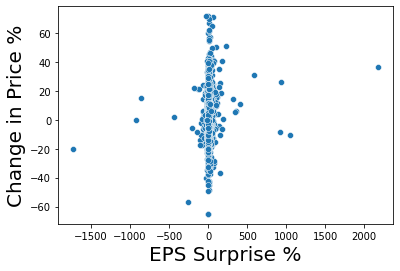

In [149]:
p = sns.scatterplot(data=df_final, x="epssurprisepct", y="close_change")
p.set_xlabel("EPS Surprise %", fontsize = 20)
p.set_ylabel("Change in Price %", fontsize = 20)

## Remove outliers

We zoom in to 25% to 75 % of the data (or IQR) to see if there exists any trend.

In [150]:
iqr = df_final.loc[df_final['epssurprisepct'].between(df_final['epssurprisepct'].quantile(.25), df_final['epssurprisepct'].quantile(.75), inclusive=True), :]


## Result

There was no clear relationship between the EPS Surprise and the Change in Price. The correlation coefficient matrix also further confirms this with a value of 0.085609 which is close to 8.6% correlation, being insignificant. 

From this we can safely conclude that<span style="color:blue;font-weight:bold"> using only EPS Surprise as a indicator to predict stock price movements is naive.</span> Further explorations can be done at sector level and for other stocks.

Text(0, 0.5, 'Change in Price %')

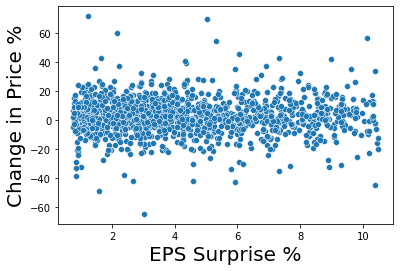

In [151]:
p = sns.scatterplot(data=iqr, x="epssurprisepct", y="close_change")
p.set_xlabel("EPS Surprise %", fontsize = 20)
p.set_ylabel("Change in Price %", fontsize = 20)

In [152]:
df_final.corr()

,close,epssurprisepct,close_change
close,1.000000,-0.037577,-0.078836
epssurprisepct,-0.037577,1.000000,0.085609
close_change,-0.078836,0.085609,1.000000
